# 03.00 Cluster Analysis Using DBScan
## Issue 1279
---
### *Used small subset since 1M+ dataset was too large to run locally. The code is here for when the ability to run the larger set is possible.*
### Conclusion: There seems to be clusters based on location, agencyId, and typeID. This can be explored further to identify areas that have repeat request types which also require the same agency to be dispatched. 

# ADD IN POPULATION DATA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN, KMeans

In [2]:
# 311 Data 10/01/2021-10/01/2022 from API see 01 notebook
raw_df = pd.read_csv('../data/clean_01Oct21_01Oct22_api.csv')
df = raw_df.copy()

# Anupriya's Population Data
raw_pop = pd.read_csv('../data/pop_tracts_nc_final.csv')
pop = raw_pop.copy()

In [3]:
print(df.shape)
df.head()

(1042202, 16)


,requestId,createdDate,closedDate,typeId,typeName,address,latitude,longitude,agencyId,agencyName,sourceId,srnumber,sourceName,councilId,councilName,councilID
0,8610592,2021-10-01 00:01:14,2021-10-08 09:24:53,4,Bulky Items,"11614 N HERRICK AVE, 91340",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079512481,Phone Call,64,Pacoima,64
1,8610569,2021-10-01 00:02:19,2021-10-08 13:36:33,5,Electronic Waste,"11614 N HERRICK AVE, 91340",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516251,Phone Call,64,Pacoima,64
2,8610575,2021-10-01 00:03:11,2021-10-13 12:31:58,4,Bulky Items,"4539 N VISTA DEL MONTE AVE, 91403",34.154158,-118.450025,3,Sanitation Bureau,8,1-2079512561,Phone Call,72,Sherman Oaks,72
3,8612855,2021-10-01 00:04:14,2021-10-05 14:25:02,6,Illegal Dumping,"918 W COLLEGE ST, 90012",34.066466,-118.245113,3,Sanitation Bureau,3,1-2079516331,Email,38,Historic Cultural North,38
4,8610587,2021-10-01 00:05:25,2021-10-08 14:16:32,7,Metal/Appliances,"11614 N HERRICK AVE, 91340",34.281312,-118.425453,3,Sanitation Bureau,8,1-2079516401,Phone Call,64,Pacoima,64


In [24]:
df[['typeId', 'typeName']].value_counts()

typeId  typeName             
4       Bulky Items              490106
1       Graffiti                 251080
7       Metal/Appliances          85094
6       Illegal Dumping           83683
2       Homeless Encampment       43412
5       Electronic Waste          30703
3       Animal Remains            22574
11      Other                     15150
9       Multiple Streetlights      8887
8       Single Streetlight         8237
10      Water Waste                2995
12      Feedback                    281
dtype: int64

# Create Latitude Longitude Zone Identifier Using KNN?

In [4]:
ll_X = df[['latitude', 'longitude']]

# Scale variables
ll_sc = StandardScaler()
ll_X_sc = ll_sc.fit_transform(ll_X)

In [5]:
# Look for best Inertia
'''
inertia_list = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(ll_X_sc)
    inertia_list.append(kmeans.inertia_)

inertia_list
'''

'\ninertia_list = []\n\nfor k in range(1, 11):\n    kmeans = KMeans(n_clusters = k, random_state = 42)\n    kmeans.fit(ll_X_sc)\n    inertia_list.append(kmeans.inertia_)\n\ninertia_list\n'

In [6]:
'''
plt.plot(range(1,11), inertia_list, marker = 'o')
plt.xlabel('# of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia Scores')
'''

"\nplt.plot(range(1,11), inertia_list, marker = 'o')\nplt.xlabel('# of Clusters')\nplt.ylabel('Inertia')\nplt.title('Inertia Scores')\n"

In [7]:
# Look for best silhouette
'''
silhouette_list = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(ll_X_sc)
    silhouette_list.append(silhouette_score(ll_X_sc, kmeans.labels_))
    
silhouette_list
'''

'\nsilhouette_list = []\n\nfor k in range(2, 11):\n    kmeans = KMeans(n_clusters = k, random_state = 42)\n    kmeans.fit(ll_X_sc)\n    silhouette_list.append(silhouette_score(ll_X_sc, kmeans.labels_))\n    \nsilhouette_list\n'

In [8]:
'''
plt.plot(range(2, 11), silhouette_list, marker='o')
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Silhouette Scores');
'''

"\nplt.plot(range(2, 11), silhouette_list, marker='o')\nplt.xlabel('# of Clusters')\nplt.ylabel('Score')\nplt.title('Silhouette Scores');\n"

# Clustering - DBSCAN

In [9]:
# X = df[['typeId', 'latitude', 'longitude', 'agencyId', 'sourceId', 'councilId']]
X = df[['typeId', 'councilId']]
print(df.shape)
X.head()

(1042202, 16)


,typeId,councilId
0,4,64
1,5,64
2,4,72
3,6,38
4,7,64


In [10]:
# smaller dataset for processing
# df_test = df.sample(frac = .01, random_state = 42)
X_test = X[:1000].copy()

In [11]:
# Adapted from function created by Jeff Hale

def find_best_silhouette(X):     
    ss = StandardScaler()
    X_scaled = ss.fit_transform(X)
    max_score=-1
    for eps in np.linspace(0.2, 5, 50):
        for minsamples in range(2, round(len(X) / 2)):
            dbscan = DBSCAN(eps=eps, min_samples=minsamples)
            dbscan.fit(X_scaled)
            if len(set(dbscan.labels_)) > 1:
                score = silhouette_score(X_scaled, dbscan.labels_)
                if -1 in set(dbscan.labels_):
                    nclusters = len(set(dbscan.labels_)) - 1
                else:
                    nclusters = len(set(dbscan.labels_)) 
                if score > max_score:
                    max_score = score
                    best_eps = eps
                    best_min_samples = minsamples
                    best_clusters = nclusters
    print(f'Best silhouette score was {round(max_score, 5)}')
    print(f'Best eps was {round(best_eps, 2)}')
    print(f'Best min_samples was {best_min_samples}.')
    print(f'Model found {best_clusters} clusters.')
    return best_eps, best_min_samples

In [12]:
best_eps, best_min_samples = find_best_silhouette(X_test)

Best silhouette score was 0.50387
Best eps was 0.98
Best min_samples was 52.
Model found 1 clusters.


In [13]:
# Scale dataframe
ss = StandardScaler()
X_sc = ss.fit_transform(X_test)

In [14]:
# Fit DBSCAN with best parameters
dbscan = DBSCAN(eps = best_eps, min_samples = best_min_samples) 
dbscan.fit(X_sc)

DBSCAN(eps=0.9836734693877551, min_samples=52)

## Evaluation
---

In [15]:
# Labels
print(pd.Series(dbscan.labels_).unique())

[ 0 -1]


In [16]:
silhouette_score(X_sc, dbscan.labels_) # -1 to 1

0.5038718344221602

In [18]:
# Create cluster column
X_test['cluster'] = dbscan.labels_

In [21]:
X_test.cluster.value_counts(normalize = True, ascending = False)

 0    0.973
-1    0.027
Name: cluster, dtype: float64

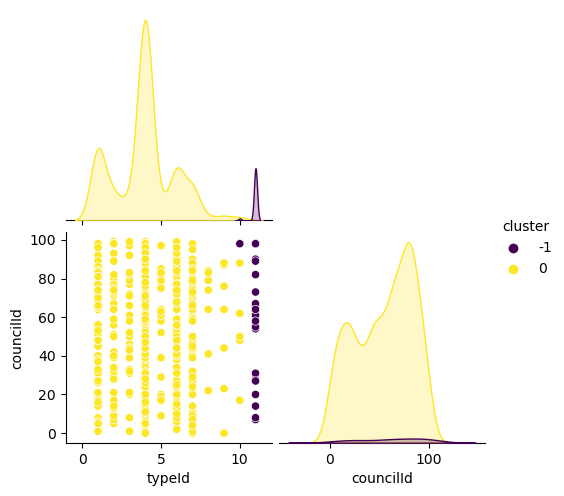

In [22]:
# Pairplot
sns.pairplot(X_test, hue = 'cluster', palette = 'viridis', corner = True)